In [166]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

import seaborn as sns
import matplotlib.pyplot as plt

## Création de notre base de donnée finale

In [167]:
# Importation des bdd

db01 = pd.read_csv("../gitignore/title_basics_traite.csv")
db02 = pd.read_csv("../gitignore/title_ratings_final.tsv", sep="\t")
db03 = pd.read_csv("../gitignore/title.akas_final.tsv", sep="\t")
db04 = pd.read_csv("../gitignore/tmdb_ml_final.csv")
db05 = pd.read_csv("../gitignore/data_bechdel.csv")
db07 = pd.read_csv("../gitignore/name.basics.tsv", sep="\t")
db08 = pd.read_csv("../gitignore/title.crew.tsv", sep="\t")

In [168]:
# Merge des bdd entre elles

dbmerge_1 = pd.merge(db01, db02, right_on='title_ratings_tconst', left_on='tconst', how='left') #Title Basics + Title Ratings
dbmerge_2 = pd.merge(dbmerge_1, db03, left_on='tconst', right_on='titleId', how='left') # + Title Akas
dbmerge_3 = pd.merge(dbmerge_2, db04, left_on='tconst', right_on='tmdb_imdb_id', how='left') # + TMDB Full
dbmerge_4 = pd.merge(dbmerge_3, db05, left_on='tconst', right_on='imdbid', how='left') # + Bechdel
dbmerge_4 = pd.merge(dbmerge_4, db08, left_on='tconst', right_on='tconst', how='left') # + Title Crew
dbmerge_4 = pd.merge(dbmerge_4, db07, left_on='directors', right_on='nconst', how='left') # + Name Basics

In [169]:
dbmerge_4[dbmerge_4['tconst'] == 'tt8852130']

,tconst,titleType,startYear,runtimeMinutes,genres,decade,Action,Adult,Adventure,Animation,...,rating,imdbid,directors,writers,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
669245,tt8852130,movie,2018,115,Family,2010,False,False,False,False,...,NaN,NaN,nm10047650,"nm12539134,nm10047650",nm10047650,Ravi Punj,\N,\N,"director,writer,producer","tt32096430,tt8852130,tt31869928,tt11173174"


In [170]:
# Suppresion des colonnes inutiles

BIG_DF_ML = dbmerge_4.drop(columns=[
    'titleType',
    'genres', 
    'decade', 
    'Adult',
    'Short',
    'movie',
    'tmdb_Comedy',
    'tmdb_Adventure',
    'tmdb_Drama',
    'tmdb_Crime',
    'tmdb_Action',
    'tmdb_Documentary',
    'tmdb_Animation',
    'tmdb_Mystery',
    'tmdb_Horror',
    'tmdb_Western',
    'tmdb_Science Fiction',
    'tmdb_Thriller',
    'tmdb_Romance',
    'tmdb_Fantasy',
    'tmdb_Family',
    'tmdb_History',
    'tmdb_Music',
    'tmdb_War', 
    'ordering',
    'region',
    'language',
    'types',
    'attributes',
    'isOriginalTitle',
    'birthYear',
    'deathYear',
    'primaryProfession',
    'knownForTitles',
    'directors',
    'writers'
])

In [171]:
BIG_DF_ML.loc[(dbmerge_4['title_ratings_averageRating'].isnull())&(dbmerge_4['tmdb_vote_average'].isnull()), ['title_ratings_tconst', 'title_ratings_averageRating', 'tmdb_vote_average']]

,title_ratings_tconst,title_ratings_averageRating,tmdb_vote_average
9,NaN,NaN,NaN
10,NaN,NaN,NaN
11,NaN,NaN,NaN
12,NaN,NaN,NaN
13,NaN,NaN,NaN
...,...,...,...
688329,NaN,NaN,NaN
688335,NaN,NaN,NaN
688336,NaN,NaN,NaN
688337,NaN,NaN,NaN


In [172]:
BIG_DF_ML3 = BIG_DF_ML.dropna(subset=['title_ratings_averageRating','tmdb_vote_average'],how='all')

In [ ]:
# Création d'une moyenne pondérée entre les notes title_ratings et tmdb en fonction du nombre de votants

def moyenne_ponderee(ligne):

    # Si 'title_ratings_averageRating' est NaN, on ne prend que 'tmdb_vote_average', et vice versa

    if pd.isna(ligne['title_ratings_averageRating']) and not pd.isna(ligne['tmdb_vote_average']):
        return ligne['tmdb_vote_average']  # Si title_ratings_averageRating est vide, prendre tmdb_vote_average

    elif pd.isna(ligne['tmdb_vote_average']) and not pd.isna(ligne['title_ratings_averageRating']):
        return ligne['title_ratings_averageRating']  # Si tmdb_vote_average est vide, prendre title_ratings_averageRating

    elif not pd.isna(ligne['title_ratings_averageRating']) and not pd.isna(ligne['tmdb_vote_average']):
        # Si les deux colonnes ont des valeurs, calculer la moyenne pondérée
        return (ligne['title_ratings_averageRating'] * ligne['title_ratings_numVotes'] + ligne['tmdb_vote_average'] * ligne['tmdb_vote_count']) / (ligne['title_ratings_numVotes'] + ligne['tmdb_vote_count'])  # Moyenne simple, à ajuster si besoin !
    else:
        return np.nan  # Si les deux sont NaN, retourner NaN


BIG_DF_ML3['notes'] = BIG_DF_ML3.apply(moyenne_ponderee, axis=1)

In [174]:
# Suppression des films sortis avant 1920
BIG_DF_ML3 = BIG_DF_ML3[BIG_DF_ML3['startYear'] >= 1920]

In [175]:
BIG_DF_ML3.describe()

,startYear,runtimeMinutes,title_ratings_averageRating,title_ratings_numVotes,tmdb_popularity,tmdb_release_date,tmdb_runtime,tmdb_vote_average,tmdb_vote_count,rating,notes
count,327847.000000,327847.00000,313459.000000,3.134590e+05,201312.000000,201312.000000,201312.000000,201312.000000,201312.000000,9586.000000,327847.000000
mean,1996.062666,84.33487,6.177591,3.704412e+03,3.382595,1968.703589,86.042993,4.377985,95.716232,2.157730,5.949025
std,26.018551,165.19044,1.385250,3.685595e+04,26.082977,225.222552,109.149827,2.812918,726.228894,1.074264,1.782200
min,1920.000000,0.00000,1.000000,5.000000e+00,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1980.000000,74.00000,5.300000,1.900000e+01,0.695000,1975.000000,78.000000,1.761500,1.000000,1.000000,5.200000
50%,2007.000000,90.00000,6.300000,6.300000e+01,1.305000,2004.000000,90.000000,5.300000,3.000000,3.000000,6.200000
75%,2016.000000,101.00000,7.100000,3.270000e+02,2.512000,2015.000000,103.000000,6.417000,13.000000,3.000000,7.090908
max,2026.000000,59460.00000,10.000000,2.965080e+06,5089.969000,2024.000000,43200.000000,10.000000,33630.000000,3.000000,10.000000


In [205]:
# Suppression de 75% des films en se basant sur le nombre de votes inférieurs à 327
BIG_DF_ML3 = BIG_DF_ML3[BIG_DF_ML3['title_ratings_numVotes'] >= 327]
index = BIG_DF_ML3.index

Beaucoup de films (environ 3000) ont des durées égales à 0. Après vérification, ce sont juste des films dont la durée n'est pas renseignée sur IMDB. Nous avons décidé des les garder car certains sont bien notés.

Nous décidons également de ne garder que les films qui ont été notés par 327 personnes au minimum (25% des films). On appliquera ce filtre plus tard pour ne pas supprimer ces éléments de la recherche.

In [206]:
# Suppression des dernières colonnes inutiles

BIG_DF_ML4 = BIG_DF_ML3.drop(['title_ratings_averageRating','tmdb_vote_average','title_ratings_tconst','titleId','tmdb_imdb_id','imdbid', 'primaryName'], axis=1)

In [207]:
def runtimeMinutes(ligne):

    # Si 'runtimeMinutes' est 0, il prend la valeur 'tmdb_runtime'
    BIG_DF_ML4.loc[(BIG_DF_ML4['runtimeMinutes'] == 0)&(BIG_DF_ML4['tmdb_runtime'] != 0), 'runtimeMinutes'] = BIG_DF_ML4['tmdb_runtime']

runtimeMinutes(BIG_DF_ML4)

In [208]:
def runtimeMinutes2(ligne):

    # Si 'tmdb_runtime' est 0, il prend la valeur 'runtimeMinutes'
    BIG_DF_ML4.loc[(BIG_DF_ML4['tmdb_runtime'] == 0)&(BIG_DF_ML4['runtimeMinutes'] != 0), 'tmdb_runtime'] = BIG_DF_ML4['runtimeMinutes']

runtimeMinutes2(BIG_DF_ML4)

In [209]:
BIG_DF_ML5 = BIG_DF_ML4.drop(columns =['tmdb_runtime','tmdb_release_date','tmdb_vote_count','tmdb_TV Movie'])

In [210]:
# Suppression des éléments vides

BIG_DF_ML5 = BIG_DF_ML5.dropna(subset=['runtimeMinutes'])
BIG_DF_ML5 = BIG_DF_ML5.dropna(subset=['startYear'])
BIG_DF_ML5 = BIG_DF_ML5.dropna(subset=['title'])

In [211]:
# Pour notre ML, on remplace toutes les valeurs nulles des pays de production par False 

Remplacer = [
    'tmdb_US', 'tmdb_FR', 'tmdb_GB', 'tmdb_DE', 'tmdb_JP', 'tmdb_IN', 'tmdb_IT',
    'tmdb_CA', 'tmdb_ES', 'tmdb_MX', 'tmdb_HK', 'tmdb_BR', 'tmdb_SE', 'tmdb_SU',
    'tmdb_PH', 'tmdb_KR', 'tmdb_AU', 'tmdb_CN', 'tmdb_AR', 'tmdb_RU', 'tmdb_DK',
    'tmdb_NL', 'tmdb_BE', 'tmdb_AT', 'tmdb_TR', 'tmdb_PL', 'tmdb_CH', 'tmdb_XC',
    'tmdb_FI', 'tmdb_NO', 'tmdb_IR', 'tmdb_XG', 'tmdb_EG', 'tmdb_NG', 'tmdb_ZA'
]
BIG_DF_ML5[Remplacer] = BIG_DF_ML5[Remplacer].fillna(False)

In [212]:
# Remplacement des valeurs vides 

BIG_DF_ML5['rating'] = BIG_DF_ML5['rating'].fillna(0)
BIG_DF_ML5['tmdb_popularity'] = BIG_DF_ML5['tmdb_popularity'].fillna(0)
BIG_DF_ML5['nconst'] = BIG_DF_ML5['nconst'].fillna("")

In [213]:
BIG_DF_ML5[['Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']] = BIG_DF_ML5[['Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']].astype(bool)

In [214]:
export = "../machine learning/DF_ML.csv.gz"
BIG_DF_ML5.to_csv(export, sep=",", index=False, compression="gzip")

In [215]:
df_ml = BIG_DF_ML5

## RECHERCHE K

In [216]:
from sklearn.preprocessing import MinMaxScaler

index = df_ml.index
df_ml_num = df_ml.select_dtypes('number')
df_ml_cat = df_ml.select_dtypes(['object', 'category', 'string', 'bool'])

# Normalisation des colonnes numériques
SN = MinMaxScaler()
df_ml_num_SN = pd.DataFrame(SN.fit_transform(df_ml_num), columns=df_ml_num.columns, index=index)

df_ml_encoded = pd.concat([df_ml_num_SN, df_ml_cat], axis=1)

# On sépare notre df en deux groupes, en fonction de la note
bons_films = df_ml_encoded[df_ml_encoded['notes'] >= 0.7]

# On crée une liste des colonnes à utiliser pour le modèle
caracteristiques = df_ml_encoded.columns.drop(['tconst', 'nconst', 'title', 'title_ratings_numVotes', 'rating', 
    'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History',
    'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
    'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', 
    'tmdb_US', 'tmdb_FR', 'tmdb_GB', 'tmdb_DE', 'tmdb_JP', 'tmdb_IN',
    'tmdb_IT', 'tmdb_CA', 'tmdb_ES', 'tmdb_MX', 'tmdb_HK', 'tmdb_BR',
    'tmdb_SE', 'tmdb_SU', 'tmdb_PH', 'tmdb_KR', 'tmdb_AU', 'tmdb_CN',
    'tmdb_AR', 'tmdb_RU', 'tmdb_DK', 'tmdb_NL', 'tmdb_BE', 'tmdb_AT',
    'tmdb_TR', 'tmdb_PL', 'tmdb_CH', 'tmdb_XC', 'tmdb_FI', 'tmdb_NO',
    'tmdb_IR', 'tmdb_XG', 'tmdb_EG', 'tmdb_NG', 'tmdb_ZA'])

bons_films = bons_films[caracteristiques]

In [217]:
def evaluate_k(bons_films, k_range):
    """
    Évalue différentes valeurs de k en utilisant la somme des distances aux voisins
    et le score de silhouette comme métriques.

    Args:
        bons_films (DataFrame): Données normalisées
        k_range (range): Plage de valeurs de k à tester

    Returns:
        tuple: (distances moyennes, scores de silhouette)
    """
    from tqdm import tqdm
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans

    avg_distances = []
    silhouette_scores = []

    # Ajout de tqdm autour de la boucle
    for k in tqdm(k_range, desc='Évaluation de k'):
        # Calcul des distances moyennes pour chaque k
        model = NearestNeighbors(n_neighbors=k)
        model.fit(bons_films)
        distances, _ = model.kneighbors(bons_films)
        avg_distances.append(np.mean(distances))

        # Calcul du score de silhouette
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(bons_films)
        if k > 1:  # Le score de silhouette nécessite au moins 2 clusters
            silhouette_scores.append(silhouette_score(bons_films, clusters))
        else:
            silhouette_scores.append(0)

    return avg_distances, silhouette_scores


Évaluation de k: 100%|██████████| 20/20 [00:21<00:00,  1.05s/it]


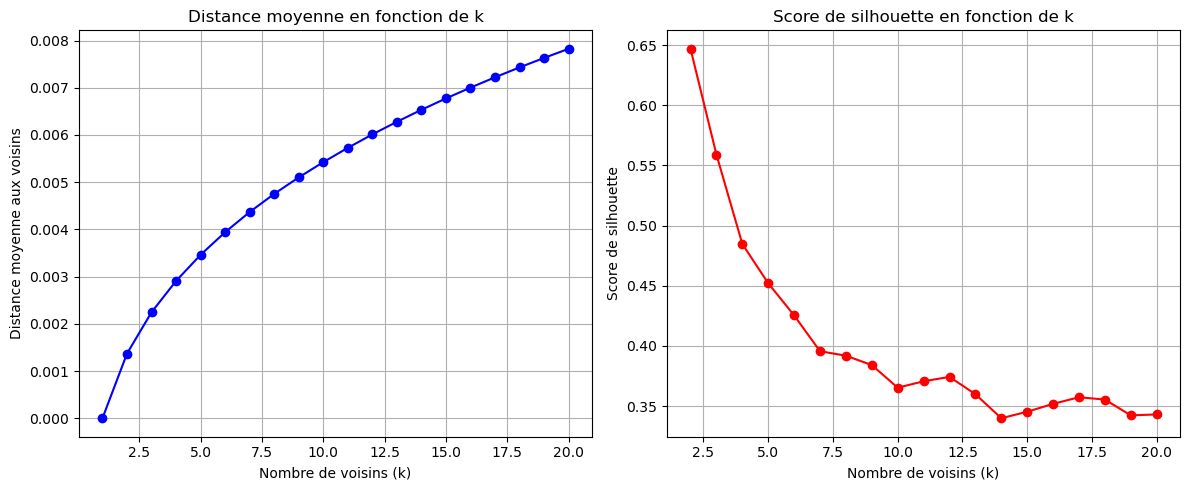

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

# Définition de la plage de k à tester
k_range = range(1, 21)  # Test des valeurs de k de 1 à 20

# Évaluation des différentes valeurs de k
avg_distances, silhouette_scores = evaluate_k(bons_films, k_range)

# Création d'une visualisation pour aider à choisir k
plt.figure(figsize=(12, 5))

# Premier graphique : Distance moyenne aux voisins
plt.subplot(1, 2, 1)
plt.plot(k_range, avg_distances, 'bo-')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Distance moyenne aux voisins')
plt.title('Distance moyenne en fonction de k')
plt.grid(True)

# Second graphique : Score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], silhouette_scores[1:], 'ro-')  # On commence à k=2
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score de silhouette')
plt.title('Score de silhouette en fonction de k')
plt.grid(True)

plt.tight_layout()
plt.show()

Décision finale : k = 6

## Fonctions ML

On veut entrainer notre modèle sur tout le dataframe et afficher UNIQUEMENT les films les plus proches dont les notes sont supérieures à 7.

Première reco : 5 films avec genres similaires et du même pays de production 

In [219]:
def recommandation(tconst):
    import pandas as pd
    from sklearn.neighbors import NearestNeighbors
    from sklearn.preprocessing import MinMaxScaler

    # Chargement des données
    df_ml = pd.read_csv("../machine learning/DF_ML.csv.gz")

    # On récupère les valeurs genre et pays qui correspondent au film sélectionné
    df_selection = df_ml[df_ml['tconst'] == tconst]
    colonnes_genre = [
        'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History',
        'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
        'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western'
    ]
    colonnes_pays = [
        'tmdb_US', 'tmdb_FR', 'tmdb_GB', 'tmdb_DE', 'tmdb_JP', 'tmdb_IN',
        'tmdb_IT', 'tmdb_CA', 'tmdb_ES', 'tmdb_MX', 'tmdb_HK', 'tmdb_BR',
        'tmdb_SE', 'tmdb_SU', 'tmdb_PH', 'tmdb_KR', 'tmdb_AU', 'tmdb_CN',
        'tmdb_AR', 'tmdb_RU', 'tmdb_DK', 'tmdb_NL', 'tmdb_BE', 'tmdb_AT',
        'tmdb_TR', 'tmdb_PL', 'tmdb_CH', 'tmdb_XC', 'tmdb_FI', 'tmdb_NO',
        'tmdb_IR', 'tmdb_XG', 'tmdb_EG', 'tmdb_NG', 'tmdb_ZA'
    ]

    genre = [colonne for colonne in df_selection.columns if df_selection[colonne].iloc[0] == True and colonne in colonnes_genre]
    pays = [colonne for colonne in df_selection.columns if df_selection[colonne].iloc[0] == True and colonne in colonnes_pays]

    index = df_ml.index
    df_ml_num = df_ml.select_dtypes('number')
    df_ml_cat = df_ml.select_dtypes(['object', 'category', 'string', 'bool'])

    # Normalisation des colonnes numériques
    SN = MinMaxScaler()
    df_ml_num_SN = pd.DataFrame(SN.fit_transform(df_ml_num), columns=df_ml_num.columns, index=index)

    df_ml_encoded = pd.concat([df_ml_num_SN, df_ml_cat], axis=1)

    # On sépare notre df en deux groupes, en fonction de la note
    bons_films = df_ml_encoded[df_ml_encoded['notes'] >= 0.7]
    
    # On crée une liste des colonnes à utiliser pour le modèle
    caracteristiques = df_ml_encoded.columns.drop(['tconst', 'nconst', 'title', 'title_ratings_numVotes', 'rating', 
        'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History',
        'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
        'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', 
        'tmdb_US', 'tmdb_FR', 'tmdb_GB', 'tmdb_DE', 'tmdb_JP', 'tmdb_IN',
        'tmdb_IT', 'tmdb_CA', 'tmdb_ES', 'tmdb_MX', 'tmdb_HK', 'tmdb_BR',
        'tmdb_SE', 'tmdb_SU', 'tmdb_PH', 'tmdb_KR', 'tmdb_AU', 'tmdb_CN',
        'tmdb_AR', 'tmdb_RU', 'tmdb_DK', 'tmdb_NL', 'tmdb_BE', 'tmdb_AT',
        'tmdb_TR', 'tmdb_PL', 'tmdb_CH', 'tmdb_XC', 'tmdb_FI', 'tmdb_NO',
        'tmdb_IR', 'tmdb_XG', 'tmdb_EG', 'tmdb_NG', 'tmdb_ZA'])

    # On veut que nos recommandations aient automatiquement un genre en commun et un pays de prod en commun
    bons_films = bons_films[bons_films[genre].any(axis=1)] if genre else bons_films
    bons_films = bons_films[bons_films[pays].any(axis=1)] if pays else bons_films

    # On crée notre modèle
    model = NearestNeighbors(n_neighbors=6, metric='euclidean')
    model.fit(bons_films[caracteristiques])

    # On déclare les caractéristiques du film sélectionné par l'utilisateur
    caract_film = df_ml_encoded[df_ml_encoded['tconst'] == tconst][caracteristiques]

    # On calcule les distances et indices des voisins
    distances, indices = model.kneighbors(caract_film)

    # On affiche la sélection des films en fonction des indices trouvés par le modèle
    if caract_film['notes'].values[0] > 0.7:
        distances = distances[0][1:6]
        indices = indices[0][1:6]
        selection = bons_films.iloc[indices]['tconst']
    else:
        distances = distances[0][0:5]
        indices = indices[0][0:5]
        selection = bons_films.iloc[indices]['tconst']

    selection = pd.DataFrame(selection).reset_index(drop=True)

    return selection

In [220]:
recommandation('tt0120338')

,tconst
0,tt0118749
1,tt0117666
2,tt0175880
3,tt0140352
4,tt0119174


Deuxième reco : 5 films avec genres similaires et pays de production différent

In [221]:
def recommandation2(tconst):

    df_ml = pd.read_csv("../machine learning/DF_ML.csv.gz")

    #On récupère les valeurs genre et pays qui correspondent au film selectionné
    df_selection = df_ml[df_ml['tconst'] == tconst]
    colonnes_genre = ['Action', 'Adventure',
    'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
    'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
    'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']

    colonnes_pays = ['tmdb_US',
        'tmdb_FR', 'tmdb_GB', 'tmdb_DE', 'tmdb_JP', 'tmdb_IN', 'tmdb_IT',
        'tmdb_CA', 'tmdb_ES', 'tmdb_MX', 'tmdb_HK', 'tmdb_BR', 'tmdb_SE',
        'tmdb_SU', 'tmdb_PH', 'tmdb_KR', 'tmdb_AU', 'tmdb_CN', 'tmdb_AR',
        'tmdb_RU', 'tmdb_DK', 'tmdb_NL', 'tmdb_BE', 'tmdb_AT', 'tmdb_TR',
        'tmdb_PL', 'tmdb_CH', 'tmdb_XC', 'tmdb_FI', 'tmdb_NO', 'tmdb_IR',
        'tmdb_XG', 'tmdb_EG', 'tmdb_NG', 'tmdb_ZA']

    genre = [colonne for colonne in df_selection.columns if df_selection[colonne].iloc[0] == True and colonne in colonnes_genre]
    pays = [colonne for colonne in df_selection.columns if df_selection[colonne].iloc[0] == True and colonne in colonnes_pays]

    index = df_ml.index
    df_ml_num = df_ml.select_dtypes('number')
    df_ml_cat = df_ml.select_dtypes(['object', 'category', 'string', 'bool'])

    from sklearn.preprocessing import MinMaxScaler
    SN = MinMaxScaler()
    df_ml_num_SN = pd.DataFrame(SN.fit_transform(df_ml_num), columns=df_ml_num.columns, index=index)

    df_ml_encoded = pd.concat([df_ml_num_SN, df_ml_cat], axis=1)

    #On crée une liste des colonnes à utiliser pour le modèle
    caracteristiques = df_ml_encoded.columns.drop(['tconst', 'nconst', 'title', 'title_ratings_numVotes', 'rating',
        'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History',
        'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
        'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', 
        'tmdb_US', 'tmdb_FR', 'tmdb_GB', 'tmdb_DE', 'tmdb_JP', 'tmdb_IN',
        'tmdb_IT', 'tmdb_CA', 'tmdb_ES', 'tmdb_MX', 'tmdb_HK', 'tmdb_BR',
        'tmdb_SE', 'tmdb_SU', 'tmdb_PH', 'tmdb_KR', 'tmdb_AU', 'tmdb_CN',
        'tmdb_AR', 'tmdb_RU', 'tmdb_DK', 'tmdb_NL', 'tmdb_BE', 'tmdb_AT',
        'tmdb_TR', 'tmdb_PL', 'tmdb_CH', 'tmdb_XC', 'tmdb_FI', 'tmdb_NO',
        'tmdb_IR', 'tmdb_XG', 'tmdb_EG', 'tmdb_NG', 'tmdb_ZA'])

    #On sépare notre df en deux groupes, en fonction de la note
    bons_films = df_ml_encoded[df_ml_encoded['notes'] >= 0.7]

    #On veut que nos recommandations aient automatiquement un genre en commun et un pays de prod en commun
    bons_films = bons_films[bons_films[genre].any(axis=1)]
    bons_films = bons_films[~bons_films[pays].any(axis=1)]

    #On crée notre modèle
    model = NearestNeighbors(n_neighbors=6, metric='euclidean')
    model.fit(bons_films[caracteristiques])

    #On déclare les caractéristiques du film sélectionné par l'utilisateur
    caract_film = df_ml_encoded[df_ml_encoded['tconst'] == tconst]
    caract_film = caract_film[caracteristiques]
    caract_film

    distances, indices = model.kneighbors(caract_film)

    #On affiche la selection des films en fonction des indices trouvés par le modèle
    if caract_film['notes'].values[0] > 0.7:
        distances = distances[0][1:6]
        indices = indices[0][1:6]
        selection = bons_films.iloc[indices]['tconst']
    else:
        distances = distances[0][0:5]
        indices = indices[0][0:5]
        selection = bons_films.iloc[indices]['tconst']

    selection = pd.DataFrame(selection).reset_index(drop=True)

    return selection

In [222]:
recommandation2('tt0120338')

,tconst
0,tt0120731
1,tt0139872
2,tt0156794
3,tt0249361
4,tt0115751


Fonction finale qui regroupe les deux à utiliser dans le streamlit

In [223]:
def recommandation_finale(tconst):

    import pandas as pd
    from sklearn.neighbors import NearestNeighbors
    from sklearn.preprocessing import MinMaxScaler

    # 1ere reco : 5 films avec genre commun et pays commun

    # Chargement des données
    df_ml = pd.read_csv("../machine learning/DF_ML.csv.gz")

    # Récupération des valeurs genre et pays qui correspondent au film sélectionné
    df_selection = df_ml[df_ml['tconst'] == tconst]
    colonnes_genre = [
        'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History',
        'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
        'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western'
    ]
    colonnes_pays = [
        'tmdb_US', 'tmdb_FR', 'tmdb_GB', 'tmdb_DE', 'tmdb_JP', 'tmdb_IN',
        'tmdb_IT', 'tmdb_CA', 'tmdb_ES', 'tmdb_MX', 'tmdb_HK', 'tmdb_BR',
        'tmdb_SE', 'tmdb_SU', 'tmdb_PH', 'tmdb_KR', 'tmdb_AU', 'tmdb_CN',
        'tmdb_AR', 'tmdb_RU', 'tmdb_DK', 'tmdb_NL', 'tmdb_BE', 'tmdb_AT',
        'tmdb_TR', 'tmdb_PL', 'tmdb_CH', 'tmdb_XC', 'tmdb_FI', 'tmdb_NO',
        'tmdb_IR', 'tmdb_XG', 'tmdb_EG', 'tmdb_NG', 'tmdb_ZA'
    ]

    genre = [colonne for colonne in df_selection.columns if df_selection[colonne].iloc[0] == True and colonne in colonnes_genre]
    pays = [colonne for colonne in df_selection.columns if df_selection[colonne].iloc[0] == True and colonne in colonnes_pays]

    index = df_ml.index
    df_ml_num = df_ml.select_dtypes('number')
    df_ml_cat = df_ml.select_dtypes(['object', 'category', 'string', 'bool'])

    # Normalisation des colonnes numériques
    SN = MinMaxScaler()
    df_ml_num_SN = pd.DataFrame(SN.fit_transform(df_ml_num), columns=df_ml_num.columns, index=index)

    df_ml_encoded = pd.concat([df_ml_num_SN, df_ml_cat], axis=1)

    # Sélection des films en fonction de la note
    bons_films = df_ml_encoded[df_ml_encoded['notes'] >= 0.7]
    
    # Création d'une liste de colonnes à utiliser pour le modèle
    caracteristiques = df_ml_encoded.columns.drop(['tconst', 'nconst', 'title', 'title_ratings_numVotes', 'rating', 
        'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
        'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History',
        'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV',
        'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', 
        'tmdb_US', 'tmdb_FR', 'tmdb_GB', 'tmdb_DE', 'tmdb_JP', 'tmdb_IN',
        'tmdb_IT', 'tmdb_CA', 'tmdb_ES', 'tmdb_MX', 'tmdb_HK', 'tmdb_BR',
        'tmdb_SE', 'tmdb_SU', 'tmdb_PH', 'tmdb_KR', 'tmdb_AU', 'tmdb_CN',
        'tmdb_AR', 'tmdb_RU', 'tmdb_DK', 'tmdb_NL', 'tmdb_BE', 'tmdb_AT',
        'tmdb_TR', 'tmdb_PL', 'tmdb_CH', 'tmdb_XC', 'tmdb_FI', 'tmdb_NO',
        'tmdb_IR', 'tmdb_XG', 'tmdb_EG', 'tmdb_NG', 'tmdb_ZA'])

    # On veut que nos recommandations aient automatiquement un genre en commun et un pays de prod en commun avec le film selectionné
    bons_films = bons_films[bons_films[genre].any(axis=1)]
    bons_films = bons_films[bons_films[pays].any(axis=1)]

    # Création de notre modèle
    model = NearestNeighbors(n_neighbors=6, metric='euclidean')
    model.fit(bons_films[caracteristiques])

    # On déclare les caractéristiques du film sélectionné par l'utilisateur
    caract_film = df_ml_encoded[df_ml_encoded['tconst'] == tconst][caracteristiques]

    # Calcul des distances et indices des voisins
    distances, indices = model.kneighbors(caract_film)

    # Affichage de la sélection des films en fonction des indices trouvés par le modèle
    if caract_film['notes'].values[0] > 0.7:
        distances = distances[0][1:6]
        indices = indices[0][1:6]
        selection = bons_films.iloc[indices]['tconst']
    else:
        distances = distances[0][0:5]
        indices = indices[0][0:5]
        selection = bons_films.iloc[indices]['tconst']

    selection = pd.DataFrame(selection).reset_index(drop=True)

    # 2e reco : 5 films avec genre commun et pays différent

    # Sélection des films en fonction de la note
    bons_films2 = df_ml_encoded[df_ml_encoded['notes'] >= 0.7]

    # On veut que nos recommandations aient automatiquement un genre en commun et un pays de prod différent de celui du film selectionné
    bons_films2 = bons_films2[bons_films2[genre].any(axis=1)]
    bons_films2 = bons_films2[~bons_films2[pays].any(axis=1)]

    # Création de notre modèle
    model2 = NearestNeighbors(n_neighbors=6, metric='euclidean')
    model2.fit(bons_films2[caracteristiques])

    distances2, indices2 = model2.kneighbors(caract_film)

    # Affichage de la sélection des films en fonction des indices trouvés par le modèle
    if caract_film['notes'].values[0] > 0.7:
        distances2 = distances2[0][1:6]
        indices2 = indices2[0][1:6]
        selection2 = bons_films2.iloc[indices2]['tconst']
    else:
        distances2 = distances2[0][0:5]
        indices2 = indices2[0][0:5]
        selection2 = bons_films2.iloc[indices2]['tconst']

    selection2 = pd.DataFrame(selection2).reset_index(drop=True)

    return selection, selection2


In [224]:
recommandation_finale('tt0120338')

(      tconst
 0  tt0118749
 1  tt0117666
 2  tt0175880
 3  tt0140352
 4  tt0119174,
       tconst
 0  tt0120731
 1  tt0139872
 2  tt0156794
 3  tt0249361
 4  tt0115751)